In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from encoder import *

pd.options.display.max_columns = 200

from sklearn.model_selection import TimeSeriesSplit
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score, mean_squared_error, roc_auc_score
from sklearn.linear_model import Lasso
from sklearn.tree import export_text, plot_tree
from pathlib import Path
from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score
)
from sklearn.ensemble import HistGradientBoostingClassifier
from skrub import TableVectorizer
from sklearn.model_selection import cross_val_score, cross_validate

# 00.EDA

In [2]:
PATH = "/Users/thom/Desktop/DSB_year2/interpretability_stability_algorithm_fairness/dataproject2025.csv"
df = pd.read_csv(PATH)
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
display(df.head())
display(df.info())
display(df.isnull().sum().sort_values(ascending=False).head(30))

if "DP" in df.columns:
    print("DP distribution:")
    display(df["DP"].describe())
else:
    print("No DP column found — vérifie le nom exact dans le fichier de description.")

Shape: (1086236, 39)
Columns: ['Unnamed: 0', 'issue_d', 'loan duration', 'annual_inc', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'delinq_2yrs', 'dti', 'emp_length', 'emp_title', 'fico_range_high', 'funded_amnt', 'grade', 'home_ownership', 'inq_last_6mths', 'int_rate', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'num_actv_bc_tl', 'num_bc_tl', 'num_il_tl', 'num_rev_accts', 'open_acc', 'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'revol_bal', 'revol_util', 'sub_grade', 'target', 'tax_liens', 'zip_code', 'Pct_afro_american', 'Predictions', 'Predicted probabilities']


,Unnamed: 0,issue_d,loan duration,annual_inc,avg_cur_bal,bc_open_to_buy,bc_util,delinq_2yrs,dti,emp_length,emp_title,fico_range_high,funded_amnt,grade,home_ownership,inq_last_6mths,int_rate,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,num_actv_bc_tl,num_bc_tl,num_il_tl,num_rev_accts,open_acc,pub_rec,pub_rec_bankruptcies,purpose,revol_bal,revol_util,sub_grade,target,tax_liens,zip_code,Pct_afro_american,Predictions,Predicted probabilities
0,0,2013,0,39600.0,1379.0,21564.0,16.1,0.0,2.49,2 years,other,759.0,4800.0,B,MORTGAGE,2.0,10.99,220.0,25.0,25.0,0.0,25.0,2.0,4.0,1.0,7.0,3.0,0.0,0.0,home_improvement,4136.0,16.1,B2,0,0.0,782,7.388592,0,0.053051
1,1,2013,0,55000.0,9570.0,16473.0,53.9,0.0,22.87,10+ years,other,734.0,27050.0,B,OWN,0.0,10.99,326.0,16.0,6.0,4.0,16.0,2.0,8.0,8.0,15.0,14.0,0.0,0.0,debt_consolidation,36638.0,61.2,B2,0,0.0,481,9.745456,0,0.084507
2,2,2013,0,325000.0,53306.0,13901.0,67.1,0.0,18.55,5 years,sales manager,749.0,28000.0,A,MORTGAGE,1.0,7.62,229.0,5.0,2.0,5.0,5.0,4.0,8.0,11.0,15.0,15.0,0.0,0.0,debt_consolidation,29581.0,54.6,A3,0,0.0,945,7.542862,0,0.037206
3,3,2013,0,130000.0,36362.0,3567.0,93.0,0.0,13.03,10+ years,other,719.0,12000.0,B,MORTGAGE,1.0,11.99,193.0,4.0,4.0,3.0,85.0,3.0,4.0,8.0,8.0,9.0,0.0,0.0,debt_consolidation,10805.0,67.0,B3,0,0.0,809,6.598132,0,0.061371
4,4,2013,1,73000.0,24161.0,4853.0,74.7,1.0,23.13,6 years,other,669.0,27600.0,D,MORTGAGE,1.0,19.97,294.0,4.0,4.0,4.0,4.0,5.0,11.0,4.0,16.0,10.0,0.0,0.0,debt_consolidation,27003.0,82.8,D5,1,0.0,802,7.058900,1,0.345896


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1086236 entries, 0 to 1086235
Data columns (total 39 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   Unnamed: 0               1086236 non-null  int64  
 1   issue_d                  1086236 non-null  int64  
 2   loan duration            1086236 non-null  int64  
 3   annual_inc               1086236 non-null  float64
 4   avg_cur_bal              1086236 non-null  float64
 5   bc_open_to_buy           1086236 non-null  float64
 6   bc_util                  1086236 non-null  float64
 7   delinq_2yrs              1086236 non-null  float64
 8   dti                      1086236 non-null  float64
 9   emp_length               1086236 non-null  object 
 10  emp_title                1086236 non-null  object 
 11  fico_range_high          1086236 non-null  float64
 12  funded_amnt              1086236 non-null  float64
 13  grade                    1086236 non-null 

None

Unnamed: 0               0
issue_d                  0
loan duration            0
annual_inc               0
avg_cur_bal              0
bc_open_to_buy           0
bc_util                  0
delinq_2yrs              0
dti                      0
emp_length               0
emp_title                0
fico_range_high          0
funded_amnt              0
grade                    0
home_ownership           0
inq_last_6mths           0
int_rate                 0
mo_sin_old_rev_tl_op     0
mo_sin_rcnt_rev_tl_op    0
mo_sin_rcnt_tl           0
mort_acc                 0
mths_since_recent_bc     0
num_actv_bc_tl           0
num_bc_tl                0
num_il_tl                0
num_rev_accts            0
open_acc                 0
pub_rec                  0
pub_rec_bankruptcies     0
purpose                  0
dtype: int64

No DP column found — vérifie le nom exact dans le fichier de description.


In [3]:
# Let's get rid of the Unnamed: 0 column
df = df.drop(columns=['Unnamed: 0'])

In [4]:
df = ordinal_encode(df)

In [5]:
df_clean = df.dropna(subset=["Predicted probabilities"])
df_clean = df_clean.dropna()

# On trie par ordre de date, parce qu'on ne veut pas prédire le passé avec l'avenir, un prêt accordé en 2015 ne l'était pas forcément en 2013
df_clean = df_clean.sort_values('issue_d')

print("Nb total:", len(df), " / Nb sans NaN:", len(df_clean))


y = df_clean["Predictions"]
X = df_clean.drop(columns=["Predicted probabilities", "Predictions", "target"])


X = pd.get_dummies(X, drop_first=True)


split_idx = int(len(df_clean) * 0.8) # on prend 80% de train et 20% de test


X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

Nb total: 1086236  / Nb sans NaN: 1086236


In [6]:
pipe = Pipeline([("vec", TableVectorizer()), ("clf", HistGradientBoostingClassifier())])
pipe.fit(X_train, y_train)

,steps,"[('vec', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,cardinality_threshold,40
,low_cardinality,OneHotEncoder..._output=False)
,high_cardinality,StringEncoder()
,numeric,PassThrough()
,datetime,DatetimeEncoder()
,specific_transformers,()
,drop_null_fraction,1.0


/var/folders/dr/m9v4shms079d9s6z6c8cg57m0000gn/T/ipykernel_49626/621684215.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for b, g in t.groupby('bin'):


                  bin  spd_max_abs
0  (2016.999, 2018.0]     0.550586
1    (2018.0, 2020.0]     0.904509


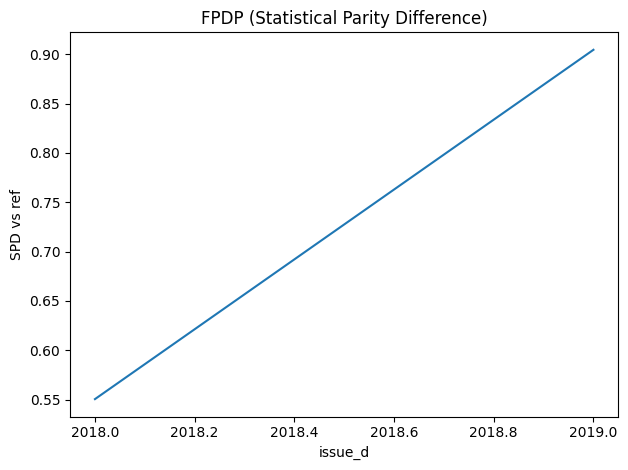

In [8]:
prot_col = 'Pct_afro_american'
if 'features' not in locals():
    _num = X.select_dtypes(include='number').columns.tolist()
    features = _num[:1] if _num else X.columns[:1]
s = df.loc[X_test.index, prot_col]
p = pipe.predict_proba(X_test)[:, 1]
yp = (p >= 0.5).astype(int)
ref = s.value_counts().idxmax()
def fpdp_spd(feature, n_bins=10, min_n=30):
    v = X_test[feature]
    bins = pd.qcut(v, q=min(n_bins, max(2, v.nunique())), duplicates='drop')
    t = pd.DataFrame({'bin': bins, 'pred': yp, 'group': s, 'val': v})
    rows = []
    for b, g in t.groupby('bin'):
        if len(g) < min_n:
            continue
        sel = g.groupby('group')['pred'].mean()
        spd = sel - sel.get(ref, np.nan)
        rows.append({'bin': str(b), 'center': g['val'].median(), 'spd_max_abs': spd.abs().max(), 'spd': spd.to_dict()})
    return pd.DataFrame(rows).sort_values('center')
res = fpdp_spd(features[0])
print(res[['bin','spd_max_abs']].head())
plt.figure()
plt.plot(res['center'], res['spd_max_abs'])
plt.xlabel(features[0]); plt.ylabel('SPD vs ref'); plt.title('FPDP (Statistical Parity Difference)')
plt.tight_layout();
plt.show()